# Métodos de Aprendizaje no supervisado

In [83]:
import pandas as pd

df = pd.read_excel('../../res/tp4/acath.xlsx', sheet_name='acath')  # 3505 rows

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,0,73,132,268.0,1,1.0
1,0,68,85,120.0,1,1.0
2,0,54,45,NaN,1,0.0
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0


In [84]:
negative = df[df.sigdz == 0]
positive = df[df.sigdz == 1]

print(f"Cantidad de filas negativas: {len(negative)}")
print(f"Cantidad de filas positivas: {len(positive)}")

# Se elige un subset de filas para igualar la proporción
positive = positive.sample(n=len(negative))

total = [negative, positive]
df = pd.concat(total)

Cantidad de filas negativas: 1170
Cantidad de filas positivas: 2334


In [85]:
df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0
11,0,35,44,257.0,0,0.0
12,1,69,10,NaN,0,0.0
20,1,52,30,240.0,0,0.0


In [86]:
import numpy as np

# Sanitize dataset
result_column = 'sigdz'
columns = ['sex', 'age', 'cad.dur', 'choleste', 'tvdlm']
numeric_columns = ['age', 'cad.dur', 'choleste']

# Replace numeric value for `sigdz` with logical value
# df.replace({result_column: {1: 'T', 0: 'F'}}, inplace=True)
# df.replace({'tvdlm': {1: 'T', 0: 'F'}}, inplace=True)
# df.replace({'sex': {1: 'F', 0: 'M'}}, inplace=True)

# Replace NaN occurrences with mean
for column in numeric_columns:
    df.replace({column: {np.nan: int(df[column].mean())}}, inplace=True)

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0
11,0,35,44,257.0,0,0.0
12,1,69,10,227.0,0,0.0
20,1,52,30,240.0,0,0.0


## Regresión Logística

In [87]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [88]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def train_model(data, fields, result_var, params=None):
    model = LogisticRegression()
    model.fit(data[fields], data[result_var])
    return model


model = train_model(train, numeric_columns, result_column)

In [89]:
predicted = model.predict(test[numeric_columns])

Población completa


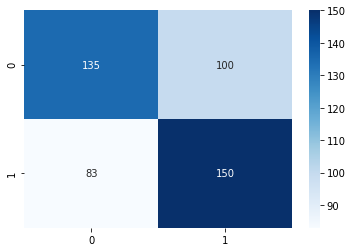

In [90]:
import seaborn as sns

def plot_confusion_matrix(data, result_var, predictions, title=None, ax=None):
    conf_mat = confusion_matrix(data[result_var], predictions)
    count_values = list(map(lambda x: sum(x), conf_mat))

    unique, counts = np.unique(np.array(data[result_var]), return_counts=True)
    count_labels = dict(zip(counts, unique))

    labels = []
    for value in count_values:
        labels.append(count_labels[value])

    if title is not None:
        print(title)

    if ax is None:
        sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    else:
        sns.heatmap(conf_mat, ax=ax, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

plot_confusion_matrix(test, result_column, predicted, title='Población completa')

In [91]:
print(classification_report(test[result_column], predicted))

              precision    recall  f1-score   support

           0       0.62      0.57      0.60       235
           1       0.60      0.64      0.62       233

    accuracy                           0.61       468
   macro avg       0.61      0.61      0.61       468
weighted avg       0.61      0.61      0.61       468



### Regresión Logística por género

In [93]:
men = df[df.sex == 0]
women = df[df.sex == 1]

train_men, test_men = train_test_split(men, test_size=0.2)
train_women, test_women = train_test_split(women, test_size=0.2)

print(f'Hombres: {len(men)}\nMujeres: {len(women)}')

Hombres: 1469
Mujeres: 871


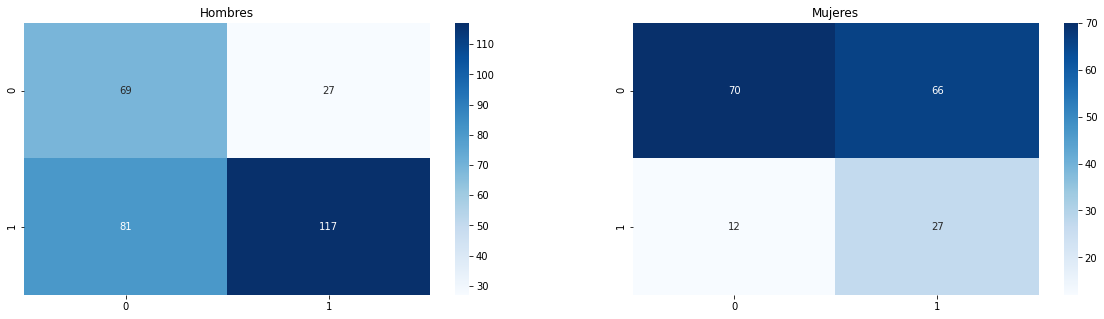

In [94]:
import matplotlib.pyplot as plt

model_men = train_model(train_men, numeric_columns, result_column)
model_women = train_model(train_women, numeric_columns, result_column)

predicted_men = model.predict(test_men[numeric_columns])
predicted_women = model.predict(test_women[numeric_columns])

tests = [test_men, test_women]
preds = [predicted_men, predicted_women]
titles = ['Hombres', 'Mujeres']

conf_mat_fig = plt.figure(figsize=(20,5))
i = 1
j = 2
k = 1
for test, pred, title in zip(tests, preds, titles):
    mat_ax = conf_mat_fig.add_subplot(i, j, k)
    mat_ax.set_title(title)
    plot_confusion_matrix(test, result_column, pred, ax=mat_ax)
    k += 1

In [95]:
for test, pred, title in zip(tests, preds, titles):
    print(title)
    print(classification_report(test[result_column], pred))

Hombres
              precision    recall  f1-score   support

           0       0.46      0.72      0.56        96
           1       0.81      0.59      0.68       198

    accuracy                           0.63       294
   macro avg       0.64      0.65      0.62       294
weighted avg       0.70      0.63      0.64       294

Mujeres
              precision    recall  f1-score   support

           0       0.85      0.51      0.64       136
           1       0.29      0.69      0.41        39

    accuracy                           0.55       175
   macro avg       0.57      0.60      0.53       175
weighted avg       0.73      0.55      0.59       175



## Agrupamiento Jerárquico

In [96]:
train_hc, test_hc = train_test_split(df, test_size=0.05)

In [99]:
normalized_df = test_hc.copy()
for column in numeric_columns:
    column_min = min(normalized_df[column])
    column_max = max(normalized_df[column])
    #print(f"{column_min} {column_max}")
    normalized_df[column] = normalized_df[column].apply(lambda x: (x - column_min) / (column_max - column_min))

normalized_df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
757,0,0.304348,0.085294,0.491597,0,0.0
546,0,0.543478,0.011765,0.521008,1,1.0
692,0,0.413043,0.200000,0.609244,1,0.0
3023,0,0.586957,0.355882,0.512605,1,0.0
429,1,0.891304,0.073529,0.735294,1,0.0


In [100]:
distance_matrix = np.zeros((len(normalized_df), len(normalized_df)))
num_norm_df = normalized_df[numeric_columns]
for i in range(len(normalized_df)):
    row_i = num_norm_df.iloc[i].to_numpy()
    for j in range(len(normalized_df)):
        if i >= j:
            continue
        row_j = num_norm_df.iloc[j].to_numpy()
        dist = np.linalg.norm(row_i - row_j)
        distance_matrix[i][j] = distance_matrix[j][i] = dist
    
    if i % 50 == 0:
        print(f"Processed {i} rows")

Processed 0 rows
Processed 50 rows
Processed 100 rows


In [101]:
print(distance_matrix)

[[0.         0.25190274 0.19701019 ... 0.49985434 0.191418   0.5421897 ]
 [0.25190274 0.         0.24542051 ... 0.28745667 0.22476822 0.35440335]
 [0.19701019 0.24542051 0.         ... 0.38896308 0.31230785 0.39233799]
 ...
 [0.49985434 0.28745667 0.38896308 ... 0.         0.50915563 0.14217071]
 [0.191418   0.22476822 0.31230785 ... 0.50915563 0.         0.55417667]
 [0.5421897  0.35440335 0.39233799 ... 0.14217071 0.55417667 0.        ]]


In [102]:
# [Nivel, Grupos]
# Grupos = [[p1, p2, p13], [p4], [p5, p9], ...] # array de sets

np.set_printoptions(linewidth=120)

def get_basic_distance_between_groups(group_1, group_2, operation):
    min_dist = None
    for point_1_index in group_1:
        for point_2_index in group_2:
            dist = distance_matrix[point_1_index][point_2_index]
            if min_dist is None or eval(f"{dist} {operation} {min_dist}"):
                min_dist = dist
    return min_dist

def get_average_distance_between_groups(group_1, group_2):
    suma = 0
    for point_1_index in group_1:
        for point_2_index in group_2:
            suma += distance_matrix[point_1_index][point_2_index]
    return suma / (len(group_1) * len(group_2))

def get_centroid_distance_between_groups(group_1_index, group_2_index, centroids):
    return np.linalg.norm(centroids[group_1_index]["centroid"] - centroids[group_2_index]["centroid"])
    
def get_distance_between_groups(groups, group_1_index, group_2_index, mode, centroids=None):
    group_1 = groups[group_1_index]
    group_2 = groups[group_2_index]
    if mode == "min":
        return get_basic_distance_between_groups(group_1, group_2, "<")
    elif mode == "max":
        return get_basic_distance_between_groups(group_1, group_2, ">")
    elif mode == "avg":
        return get_average_distance_between_groups(group_1, group_2)
    elif mode == "ctr":
        return get_centroid_distance_between_groups(group_1_index, group_2_index, centroids)
    
    raise Exception("Invalid distance mode")

def hierarchical_clustering(mode, cluster_count):
    levels = [[]]
    for i in range(len(normalized_df)):
        levels[0].append(set([i]))
    
    centroids = None # Array of centroid coordinates for each group
    if mode == "ctr":
        centroids = []
        for i in range(len(num_norm_df)):
            point = num_norm_df.iloc[i].to_numpy()
            centroids.append({"centroid": point, "points": np.array([point])})
    
    current_level = 0
    while len(levels[current_level]) > cluster_count:
        current_groups = levels[current_level]
        group_qty = len(levels[current_level])
        
        min_group_dist = None
        groups_to_merge = (None, None) # Indices
        
        for i in range(group_qty):
            for j in range(i + 1, group_qty):
                group_dist = get_distance_between_groups(current_groups, i, j, mode, centroids)
                if (min_group_dist is None) or (group_dist < min_group_dist):
                    groups_to_merge = (i, j)
                    min_group_dist = group_dist

        group_to_merge_1 = current_groups[groups_to_merge[0]]
        group_to_merge_2 = current_groups[groups_to_merge[1]]
        
        levels.append(current_groups.copy())
        new_group = set()
        new_group.update(group_to_merge_2)
        new_group.update(group_to_merge_1)
        levels[current_level + 1].append(new_group)
        levels[current_level + 1].pop(max(groups_to_merge))
        levels[current_level + 1].pop(min(groups_to_merge))
        
        if centroids is not None: # Push new group's centroid based on previous 2 centroids
            centroid_dict_1 = centroids.pop(max(groups_to_merge))
            centroid_dict_2 = centroids.pop(min(groups_to_merge))
            merged_points = np.concatenate((centroid_dict_1["points"], centroid_dict_2["points"]), axis=0)
            new_centroid_dict = {"centroid": merged_points.mean(axis=0), "points": merged_points}
            centroids.append(new_centroid_dict)

        current_level += 1
        
        if current_level % 25 == 0:
            print(f"Clusters merged: {current_level} - Distance between merged clusters was {min_group_dist}")
        
    return levels

In [115]:
from scipy import stats

def classify_clusters(clusters):
    if len(clusters) != 2:
        raise Exception("Invalid argument")
        
    cluster_1_rows = np.array(list(map(lambda x: test_hc[result_column].iloc[x], clusters[0])))
    cluster_1_mode = stats.mode(cluster_1_rows)[0][0]
    cluster_2_rows = np.array(list(map(lambda x: test_hc[result_column].iloc[x], clusters[1])))
    cluster_2_mode = stats.mode(cluster_2_rows)[0][0]
    
    return (cluster_1_mode, cluster_2_mode)

### Utilizando la Mínima como medida de similitud entre grupos

In [112]:
clusters_min_dist = hierarchical_clustering("min", 2)

Clusters merged: 25 - Distance between merged clusters was 0.03425320180045921
Clusters merged: 50 - Distance between merged clusters was 0.054038477534618684
Clusters merged: 75 - Distance between merged clusters was 0.08819126741773474
Clusters merged: 100 - Distance between merged clusters was 0.13934412659971998


In [113]:
print(clusters_min_dist[-1])

[{11}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116}]


In [116]:
classify_clusters(clusters_min_dist[-1])

(1, 1)


### Utilizando la Máxima como medida de similitud entre grupos

In [117]:
clusters_max_dist = hierarchical_clustering("max", 2)

Clusters merged: 25 - Distance between merged clusters was 0.0438743802733045
Clusters merged: 50 - Distance between merged clusters was 0.0848944879806963
Clusters merged: 75 - Distance between merged clusters was 0.15379008981523132
Clusters merged: 100 - Distance between merged clusters was 0.31389641378333144


In [118]:
print(clusters_max_dist[-1])

[{0, 1, 2, 8, 10, 14, 15, 16, 17, 19, 20, 22, 24, 25, 27, 29, 30, 33, 34, 37, 40, 41, 43, 44, 46, 47, 48, 51, 53, 54, 55, 61, 62, 63, 66, 67, 69, 71, 72, 73, 77, 78, 80, 81, 82, 85, 86, 88, 90, 91, 92, 93, 96, 97, 98, 102, 107, 108, 109, 110, 111, 112, 115}, {3, 4, 5, 6, 7, 9, 11, 12, 13, 18, 21, 23, 26, 28, 31, 32, 35, 36, 38, 39, 42, 45, 49, 50, 52, 56, 57, 58, 59, 60, 64, 65, 68, 70, 74, 75, 76, 79, 83, 84, 87, 89, 94, 95, 99, 100, 101, 103, 104, 105, 106, 113, 114, 116}]


In [119]:
classify_clusters(clusters_max_dist[-1])

(0, 1)

### Utilizando el Promedio como medida de similitud entre grupos

In [120]:
clusters_avg_dist = hierarchical_clustering("avg", 2)

Clusters merged: 25 - Distance between merged clusters was 0.042178130671802254
Clusters merged: 50 - Distance between merged clusters was 0.0777556228188955
Clusters merged: 75 - Distance between merged clusters was 0.1289830004001549
Clusters merged: 100 - Distance between merged clusters was 0.2350605637776278


In [121]:
print(clusters_avg_dist[-1])

[{89, 100, 6, 87, 105, 11, 60, 95}, {0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 88, 90, 91, 92, 93, 94, 96, 97, 98, 99, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116}]


In [122]:
classify_clusters(clusters_avg_dist[-1])

(0, 1)

### Utilizando el Centroide como medida de similitud entre grupos

In [124]:
clusters_ctr_dist = hierarchical_clustering("ctr", 2)

Clusters merged: 25 - Distance between merged clusters was 0.04043036446287498
Clusters merged: 50 - Distance between merged clusters was 0.07337362266267401
Clusters merged: 75 - Distance between merged clusters was 0.12445459061340196
Clusters merged: 100 - Distance between merged clusters was 0.21145347138653714


In [125]:
print(clusters_ctr_dist[-1])

[{81}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116}]


In [126]:
classify_clusters(clusters_ctr_dist[-1])

(0, 1)

## K-medias

In [74]:
def update_centroids(classes):
    for clase in classes.values():
        if clase["changed"]:
            clase["centroid"] = np.array(list(map(lambda x: num_norm_df.iloc[x], clase["indices"]))).mean(axis=0)
            clase["changed"] = False

K = 5
rng = np.random.default_rng()

classes = {i: {"indices": set(), "centroid": np.zeros(len(numeric_columns)), "changed": True} for i in range(1, K+1)}

random_classes = rng.integers(1, K+1, size=len(df))
for index, point_class in enumerate(random_classes):
    classes[point_class]["indices"].add(index)

while any(map(lambda x: x["changed"], classes.values())):
    update_centroids(classes)
    
    changes = []
    for clase, clase_value in classes.items():
        for point_index in clase_value["indices"]:
            point = num_norm_df.iloc[point_index]
            
            closest_class = (clase, np.linalg.norm(point - clase_value["centroid"]))
            
            # Find the closest cluster centroid
            for other_class, other_class_value in classes.items():
                if clase == other_class:
                    continue
                    
                other_centroid = other_class_value["centroid"]
                other_centroid_dist = np.linalg.norm(point - other_centroid)
                
                if other_centroid_dist < closest_class[1]:
                    closest_class = (other_class, other_centroid_dist)
            
            if closest_class[0] != clase:
                # Record belongs to another cluster, save for later update
                changes.append({"old_cluster": clase, "new_cluster": closest_class[0], "point_index": point_index})
                
    # Update clusters
    for change in changes:
        old_cluster = classes[change["old_cluster"]]
        new_cluster = classes[change["new_cluster"]]
        old_cluster["indices"].remove(change["point_index"])
        new_cluster["indices"].add(change["point_index"])
        old_cluster["changed"] = new_cluster["changed"] = True
        
    print(len(changes))
    


2786
667
288
334
377
316
213
127
128
43
36
27
18
17
20
32
38
25
18
8
5
2
1
0


In [75]:
print(classes)

{1: {'indices': {1, 5, 6, 8, 12, 13, 14, 16, 18, 21, 25, 26, 22, 28, 31, 34, 38, 39, 49, 50, 52, 53, 55, 56, 57, 64, 66, 67, 68, 71, 72, 79, 80, 86, 88, 90, 91, 94, 95, 96, 97, 99, 106, 108, 111, 114, 115, 116, 119, 120, 121, 125, 128, 130, 131, 132, 140, 141, 149, 150, 153, 163, 166, 171, 176, 180, 183, 189, 190, 191, 192, 205, 209, 212, 215, 219, 220, 223, 226, 228, 231, 234, 238, 243, 249, 252, 254, 256, 259, 260, 269, 270, 272, 276, 277, 279, 283, 284, 293, 301, 306, 307, 312, 320, 332, 334, 335, 342, 343, 345, 353, 355, 363, 368, 373, 375, 376, 378, 383, 395, 402, 404, 419, 429, 434, 438, 441, 446, 452, 463, 465, 467, 469, 473, 488, 496, 497, 499, 502, 509, 513, 515, 519, 522, 528, 540, 543, 558, 562, 565, 568, 580, 589, 592, 593, 594, 596, 597, 602, 605, 606, 608, 615, 617, 627, 638, 643, 645, 654, 669, 686, 690, 698, 719, 726, 731, 735, 742, 752, 754, 773, 784, 786, 797, 803, 810, 814, 822, 827, 833, 847, 861, 878, 882, 888, 907, 971, 973, 980, 981, 991, 996, 998, 1015, 1021, 10

In [77]:
num_norm_df.head(10)

,age,cad.dur,choleste
0,0.861538,0.317308,0.436929
1,0.784615,0.204327,0.166362
2,0.569231,0.108173,0.365631
3,0.630769,0.206731,0.394881
4,0.600000,0.016827,0.438757
5,0.723077,0.000000,0.365631
6,0.738462,0.182692,0.365631
7,0.369231,0.036058,0.398537
8,0.784615,0.072115,0.365631
9,0.538462,0.002404,0.365631
